In [2]:
import os
import sys
import math
import json
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from tqdm import tqdm
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.optimizers import Adam

gamma = 0.95
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
episode_loss = 0

action_size = 3  # buy, sell, hold
inv = []
memory = deque(maxlen=1000)

In [4]:
def model_init(state_size, action_size):
    """
    Initializes a neural network model for reinforcement learning.
    
    Parameters:
    - state_size (int): The size of the input layer, representing the state space.
    - action_size (int): The size of the output layer, representing the number of possible actions.
    
    Returns:
    - model (Sequential): The compiled Keras model ready for training.
    """
    model = Sequential()
    model.add(Dense(units=64, input_dim=state_size, activation="relu"))
    model.add(Dense(units=32, activation="relu"))
    model.add(Dense(units=8, activation="relu"))
    model.add(Dense(action_size, activation="linear"))
    model.compile(loss="mse", optimizer=Adam(learning_rate=0.001))
    return model

def act(model, state, epsilon, action_size):
    """
    Selects an action using an epsilon-greedy policy.
    
    Parameters:
    - model (Sequential): The trained model to predict Q-values.
    - state (ndarray): The current state of the environment.
    - epsilon (float): The exploration-exploitation trade-off parameter.
    - action_size (int): The number of possible actions.
    
    Returns:
    - action (int): The chosen action index.
    """
    if random.random() <= epsilon:
        return random.randrange(action_size)
    opts = model.predict(state)
    return np.argmax(opts[0])

def exp_replay(mem, model, batch_size, gamma, epsilon, epsilon_min, epsilon_decay):
    """
    Performs experience replay to train the model on past experiences.
    
    Parameters:
    - mem (deque): The memory buffer storing past experiences.
    - model (Sequential): The neural network model to be trained.
    - batch_size (int): The number of samples to draw from memory for training.
    - gamma (float): The discount factor for future rewards.
    - epsilon (float): The current exploration rate.
    - epsilon_min (float): The minimum value for epsilon.
    - epsilon_decay (float): The factor by which epsilon is multiplied after each training step.
    
    Returns:
    - mean_loss (float): The average loss over the training batch.
    """
    if len(mem) < batch_size:
        # Not enough data to process
        return 0  
    
    small_batch = random.sample(memory, batch_size)
    losses = []

    for state, action, reward, next_state, done in small_batch:
        goal = reward
        if not done:
            goal = reward + gamma * np.amax(model.predict(next_state)[0])
        goal_f = model.predict(state)
        goal_f[0][action] = goal
        loss = model.fit(state, goal_f, epochs=1, verbose=0).history['loss'][0]
        losses.append(loss)
    
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay
    
    return np.mean(losses) if losses else 0

def find_latest_checkpoint(model_dir):
    """
    Finds the latest model checkpoint in the given directory.
    
    Parameters:
    - model_dir (str): The directory where model checkpoints are saved.
    
    Returns:
    - latest_checkpoint (int or None): The latest checkpoint number, or None if no checkpoints are found.
    """
    checkpoint_files = [int(f.split('.')[0]) for f in os.listdir(model_dir) if f.endswith('.keras')]
    return max(checkpoint_files) if checkpoint_files else None


In [5]:
def stockVector(key):
    """
    Reads stock data from a CSV file and extracts the closing prices.
    
    Parameters:
    - key (str): The file name (without extension) of the CSV file containing stock data.
    
    Returns:
    - v (list of float): A list of closing prices extracted from the CSV file.
    """
    lines = open(key+".csv","r").read().splitlines()
    v = []
    for line in lines[1:]:
        v.append(float(line.split(",")[4]))
    return v

def priceFormat(p):
    """
    Formats a number as a price string with a dollar sign and two decimal places.
    
    Parameters:
    - n (float): The number to be formatted as a price.
    
    Returns:
    - formatted_price (str): The formatted price string.
    """
    if p < 0:
        sign = "-$"
    else:
        sign = "$"
    
    formatted_price = "{0:.2f}".format(abs(p))
    return sign + formatted_price

def getState(price_data, current_time, window_size):
    """
    Constructs the state representation for the trading agent based on historical stock prices.
    
    Parameters:
    - price_data (list of float): The list of historical stock prices.
    - current_time (int): The current time step.
    - window_size (int): The number of time steps to consider for the state.
    
    Returns:
    - state (ndarray): A numpy array representing the state.
    """
    start_index = current_time - window_size + 1    
    price_block = price_data[start_index:current_time + 1] if start_index >= 0 else -start_index * [price_data[0]] + price_data[0:current_time + 1]
    state = []
    for i in range(window_size - 1):
        state.append(sigmoid(price_block[i + 1] - price_block[i]))
    return np.array([state])

def sigmoid(n):
    """
    Applies the sigmoid function to a given value.
    
    Parameters:
    - x (float): The input value.
    
    Returns:
    - sigmoid_value (float): The result of applying the sigmoid function to x.
    """
    return 1/(1+math.exp(-n))

In [3]:
def train(stock_symbol, window_size, total_episodes, batch_size):
    """
    Trains a trading model on historical stock data.

    Parameters:
    - stock_symbol (str): The symbol of the stock to train on.
    - window_size (int): The number of time steps to consider for the state.
    - total_episodes (int): The total number of training episodes.
    - batch_size (int): The size of the batch for experience replay.

    Returns:
    - None
    """
    
    model_directory = "saved_models"
    losses_directory = "loss_file"
    stock_prices = stockVector(stock_symbol)
    data_length = len(stock_prices) - 1
    loss_history = []

    model = model_init(window_size, action_size)

    latest_checkpoint = find_latest_checkpoint(model_directory)
    start_episode = 0

    if latest_checkpoint:
        model = load_model(os.path.join(model_directory, f"{latest_checkpoint}.keras"))
        with open(os.path.join(losses_directory, f"losses_{latest_checkpoint}.json"), 'r') as f:
            loss_history = json.load(f)
        start_episode = latest_checkpoint + 1
        print(f"Resuming from episode {start_episode}")

    for episode in tqdm(range(start_episode, total_episodes + 1)):
        print(f"Episode {episode}/{total_episodes}")
        state = getState(stock_prices, 0, window_size + 1)
        episode_loss = 0
        total_profit = 0
        inv = []

        for step in range(data_length):
            action = act(model, state, epsilon, action_size)
            next_state = getState(stock_prices, step + 1, window_size + 1)
            reward = 0

            if action == 1:  # BUYING
                inv.append(stock_prices[step])
                print("Buy: " + priceFormat(stock_prices[step]))
            elif len(inv) > 0 and action == 2:  # SELLING
                bought_price = inv.pop(0)
                reward = max(stock_prices[step] - bought_price, 0)
                total_profit += stock_prices[step] - bought_price
                print("Sell: " + priceFormat(stock_prices[step]) + " | Profit: " + priceFormat(stock_prices[step] - bought_price))
            
            done = True if step == data_length - 1 else False
            memory.append((state, action, reward, next_state, done))
            state = next_state

            if done:
                print("#################################")
                print(f"Total Profit: {priceFormat(total_profit)}")
                print("#################################")

            if len(memory) > batch_size:
                loss = exp_replay(memory, model, batch_size, gamma, epsilon, epsilon_min, epsilon_decay)
                episode_loss += loss

        average_episode_loss = episode_loss / data_length
        loss_history.append(average_episode_loss)

        # saves every 10 episodes
        if episode % 10 == 0:  
            model.save(os.path.join(model_directory, f"{episode}.keras"))
            loss_file = os.path.join(losses_directory, f"losses_{episode}.json")
            with open(loss_file, 'w') as f:
                json.dump(loss_history, f)

train("data/AMZN", 10, 2000, 32)

NameError: name 'stockVector' is not defined

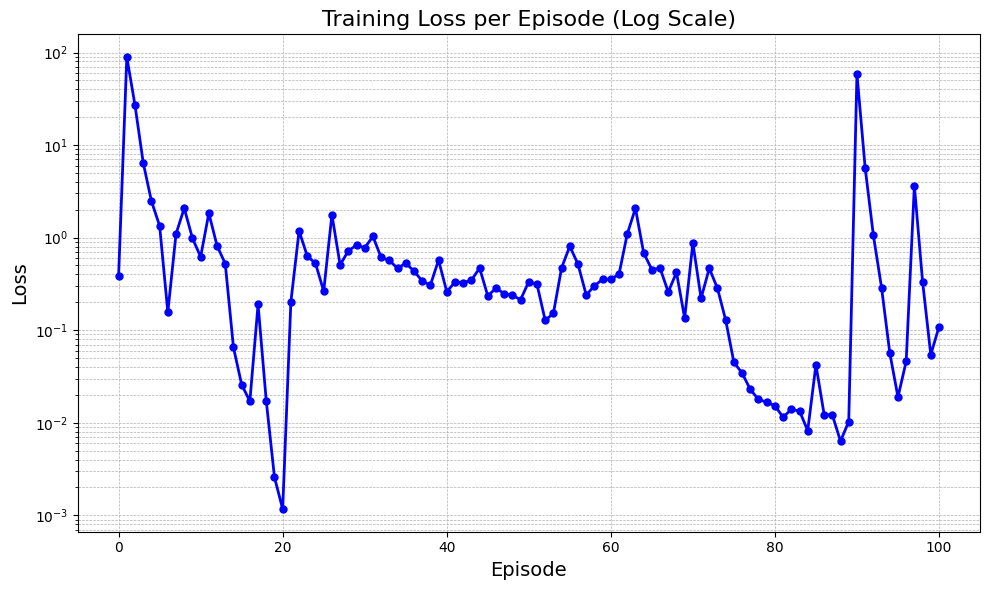

In [13]:
def load_losses_from_file(losses_file):
    with open(losses_file, 'r') as f:
        losses = json.load(f)
    return losses

episode_count = 100
losses_file = f"./loss_file/losses_{episode_count}.json"

losses = load_losses_from_file(losses_file)

# loss per episode plot
plt.figure(figsize=(10, 6))
plt.plot(range(len(losses)), losses, marker='o', linestyle='-', color='blue', markersize=5, linewidth=2)
plt.yscale('log')  # Logarithmic scale for better visibility of small values
plt.xlabel('Episode', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training Loss per Episode (Log Scale)', fontsize=16)
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()

[137.0, 138.070007, 138.600006, 139.740005, 142.710007, 142.080002, 140.600006, 143.559998, 142.589996, 145.800003, 143.199997, 142.830002, 145.179993, 146.130005, 143.899994, 146.710007, 146.740005, 147.729996, 147.029999, 146.320007, 146.089996, 147.029999, 144.839996, 146.880005, 144.520004, 146.880005, 147.419998, 145.889999, 147.479996, 148.839996, 147.419998, 149.970001, 154.070007, 153.789993, 152.119995, 153.839996, 153.419998, 153.410004, 153.339996, 153.380005, 151.940002, 149.929993, 148.470001, 144.570007, 145.240005, 149.100006, 151.369995, 153.729996, 155.179993, 154.619995, 153.160004, 151.710007, 153.5, 155.339996, 154.779999, 156.020004, 156.869995, 157.75, 159.119995, 161.259995, 159.0, 155.199997, 159.279999, 171.809998, 170.309998, 169.149994, 170.529999, 169.839996, 174.449997, 172.339996, 168.639999, 170.979996, 169.800003, 169.509995, 167.080002, 168.589996, 174.580002, 174.990005, 174.729996, 173.539993, 173.160004, 176.759995, 178.220001, 177.580002, 174.119995

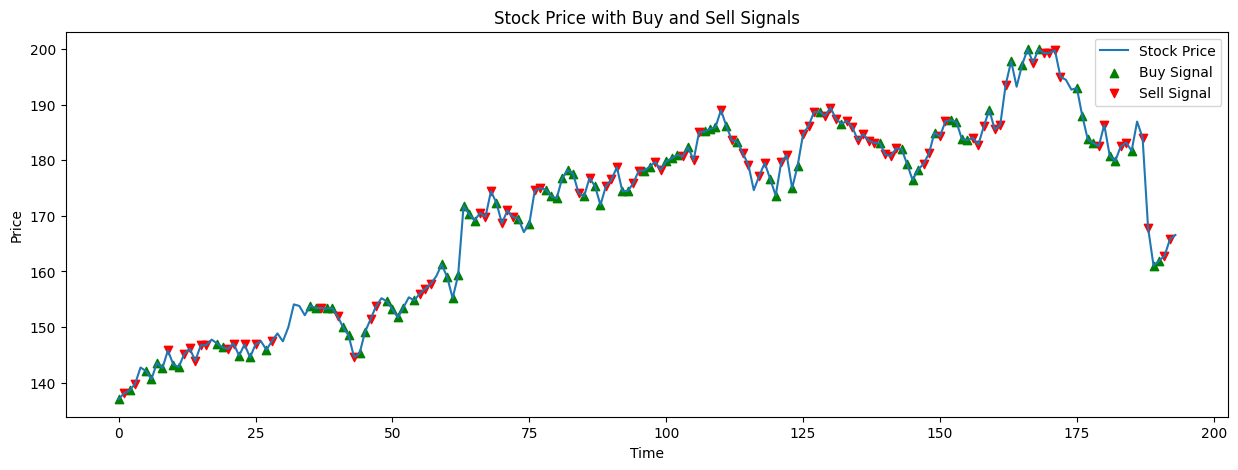

Final Total Profit: $348.05


In [10]:
def model_init_for_trading(model_name):
    """
    Initializes the model for trading by loading a pre-trained model and 
    extracting the window size from the model's input layer.

    Parameters:
    - model_name (str): The file name of the saved model to load.

    Returns:
    - model: The loaded model.
    - window_size: The size of the input window used by the model.
    """
    model = load_model(model_name)
    window_size = model.layers[0].input.shape[1]
    return model, window_size

# Choose an action
def act(model, state, epsilon=0):
    """
    Chooses an action based on the model's prediction.

    Parameters:
    - model: The trading model.
    - state: The current state of the market (input to the model).
    - epsilon (float): Exploration rate (not used in this case, hence default is 0).

    Returns:
    - int: The action chosen by the model (0 = hold, 1 = buy, 2 = sell).
    """
    options = model.predict(state)
    return np.argmax(options[0])

# Execute the trading strategy
def execute_trading_strategy(model, data, window_size):
    """
    Executes the trading strategy by simulating trades on historical stock data.

    Parameters:
    - model: The trained trading model.
    - data (list): List of stock prices.
    - window_size (int): The size of the input window used by the model.

    Returns:
    - float: The total profit earned from the trading strategy.
    """
    l = len(data) - 1
    state = getState(data, 0, window_size + 1)
    total_profit = 0
    inv = []
    memory = []
    
    # For plotting buy/sell signals
    buy_signals = []
    sell_signals = []

    for t in range(l):
        action = act(model, state)
        next_state = getState(data, t + 1, window_size + 1)
        reward = 0

        if action == 1:  # buy
            inv.append(data[t])
            buy_signals.append((t, data[t]))  # Record buy signal
            print("Buy: " + priceFormat(data[t]))
        elif action == 2 and len(inv) > 0:  # sell
            bought_price = inv.pop(0)
            reward = max(data[t] - bought_price, 0)
            total_profit += data[t] - bought_price
            sell_signals.append((t, data[t]))  # Record sell signal
            print("Sell: " + priceFormat(data[t]) + " | Profit: " + priceFormat(data[t] - bought_price))

        done = True if t == l - 1 else False
        memory.append((state, action, reward, next_state, done))
        state = next_state

        if done:
            print("################################")
            print(f"Total Profit: " + priceFormat(total_profit))
            print("################################")
            print("Total profit is:", priceFormat(total_profit))

    # Plotting the stock price with buy and sell signals
    plt.figure(figsize=(15, 5))
    plt.plot(data, label='Stock Price')
    buy_points = [p[1] for p in buy_signals]
    buy_times = [p[0] for p in buy_signals]
    sell_points = [p[1] for p in sell_signals]
    sell_times = [p[0] for p in sell_signals]

    plt.scatter(buy_times, buy_points, marker='^', color='green', label='Buy Signal', alpha=1)
    plt.scatter(sell_times, sell_points, marker='v', color='red', label='Sell Signal', alpha=1)
    plt.title('Stock Price with Buy and Sell Signals')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    return total_profit

# Initializes the trading model and executes the trading strategy on a specified stock.
def main():
    stock_name = "data/AMZN"
    model_name = "./saved_models/50.keras"
    model, window_size = model_init_for_trading(model_name)
    data = stockVector(stock_name)
    print(data)

    total_profit = execute_trading_strategy(model, data, window_size)
    print("Final Total Profit:", priceFormat(total_profit))

# Example usage
main()